# Blowing Snow Detection Algorithm

Author: Nicole Loeb<br>
Updated 19 January 2021

The following script includes the function to perform the blowing snow detection algorithm outlined in *Loeb and Kennedy (in review)*. The following flowchart outlines how the algorithm works.<br>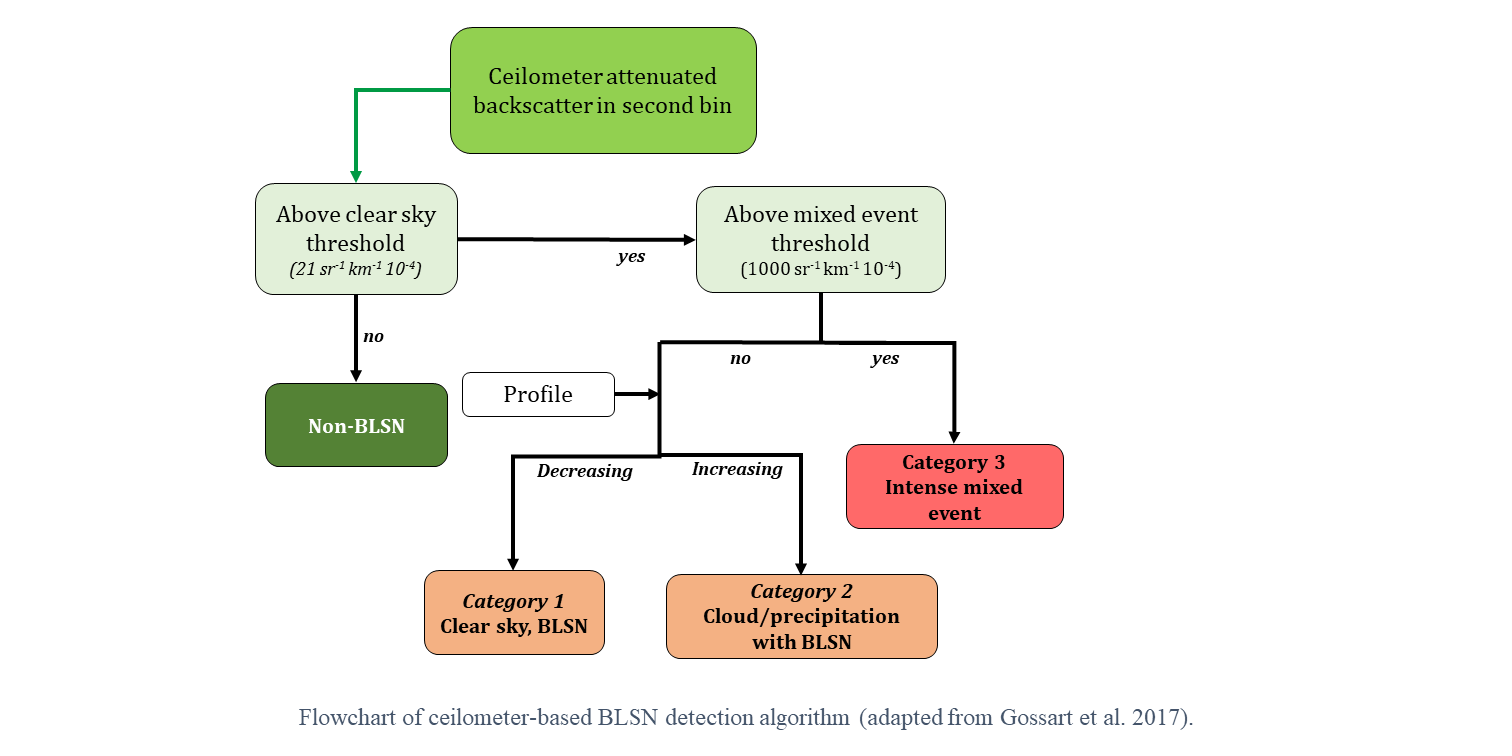<br>The following are the default thresholds:<br> - 10 m Wind speed threshold: 3 m/s<br> - 2 m Visibility threshold: 10 km<br> - 2 m Relative humidity threshold: 90%

In [14]:
# import modules
import xarray as xr
import numpy as np
import pandas as pd
import os

In [16]:
def blsnDetection(ceil_path,met_path,ceil_clr_file,
                  avg_period=5,date_range=None,wind_thres=3.,
                  vis_thres=10000.,rh_thres=90.):
    """
    This function performs the BLSN detection algorithm outlined in Loeb and
    Kennedy (2021) based on ceilometer backscatter profiles and basic
    meteorological thresholds. DOI will be added here once available. 
    
    This script is written based on the DOE ARM datasets, and may need alterations
    when used elsewhere.
    
        Modules:
            import xarray as xr
            import numpy as np
            import pandas as pd
            import os
    
        Inputs:
            ceil_path = string containing path to ceilometer data files
            met_path = string containing path to MET data files
            ceil_clr_file = string containing path and filename of csv containing
                            ceilometer clear sky profile
        
        Other Input Parameters:
            avg_period: averaging period in minutes (default = 5)
            date_range: if None - all dates in ceilometer data folder
                        if a subset: [str(start_date),str(end_date)]
                                     ex. ['2016-01-01','2017-01-01']
                               inclusive of start date, not end date
                        (default = None)
            wind_thres: threshold 10 m wind speed in m s^-1 (default = 3.0)
            vis_thres: threshold 2 m visibility in m (default = 10000.0)
            rh_thres: threshold relative humidity in % (default = 90.0)
            
        Output:
            Pandas dataframe containing the following: 
            col 0: 'datetime' - time of the start of averaging period in the
                    format ('YYYY-MM-DD hh:mm:ss') 
            col 1: 'top_of_detected_blsn' - height of top of BLSN plume, if 
                    detected [m]
            col 2: 'category' - category of detected BLSN [0 = no BLSN detected, 
                    1 = clear sky BLSN, 2 = cloud/precipitation with BLSN, 
                    3 = intense mixed event, 4 = fog]
            col 3: 'lowest_bin_backscatter' - backscatter coefficient in lowest 
                    usable bin (10-15 m AGL) [sr^-1 km^-1 10^-4]
            col 4: 'decreasing_profile' - results of check for decreasing 
                    backscatter profile with height [1 = yes, 0 = no]
            col 5: 'above_clear_sky' - results of check that backscatter in 
                    lowest usable bin > clear sky signal [1 = yes, 0 = no]
            col 6: '10m_windspeed' - 10 m wind speed average for selected 
                    averaging period [m s^-1]
            col 7: '10m_winddirection' - average 10 m wind direction for selected 
                    averaging period [deg]
            col 8: '2m_temperature' - average 2 m temperature for selected
                    averaging period [degC]
            col 9: '2m_rel_hum' - average 2 m relative humidity with respect 
                    to liquid water for selected averaging period [%]
            col 10: '2m_visibility' - average 2 m meteorological optical range 
                    visibility for selected averaging period [m]
            
            missing value code = 99999999.9
    """
    
    # initialize results dataframe
    results = pd.DataFrame([], columns=['datetime','top_of_detected_BLSN','category',
                                        'decreasing_profile','above_clear_sky','10m_windspeed',
                                        '10m_winddirection','2m_temperature','2m_rel_hum',
                                        '2m_visbility'])

    # make a sorted list of ceilometer data files
    try:
        ceil_files = [f for f in os.listdir(ceil_path) if os.path.isfile(os.path.join(ceil_path,f))]
    except OsError:
        print('Ceilometer data directory invalid')  
    ceil_files = sorted(ceil_files)
    
    # make a list of MET data files
    try:
        met_files = [f for f in os.listdir(met_path) if os.path.isfile(os.path.join(met_path,f))]
    except OsError:
        print('MET data directory invalid')
    
    # import clear sky profile
    ceil_clr = pd.read_csv(ceil_clr_file,header = None)
    ceil_clr = np.array(ceil_clr)[0]
    
    # set date range, if specified
    if date_range != None:
        start_date = np.datetime64(date_range[0])
        end_date = np.datetime64(date_range[1])
    
    # go through ceilometer data, day-by-day
    for xx in range(len(ceil_files)):
        
        try:
            
            # define date from CEIL filename
            date = ceil_files[xx][-18:-10]
            year = date[:4]
            month = date[4:6]
            day = date[6:]

            # check if date within range, if given
            if date_range != None:
                if start_date <= np.datetime64(str(year+'-'+month+'-'+day)) < end_date:
                    pass
                elif end_date <= np.datetime64(str(year+'-'+month+'-'+day)):
                    print('Completed date range')
                    break
                else:
                    print(f'{date} outside of date range')
                    continue

            #..........................CEILOMETER OBSERVATIONS..........................
            # import CEIL data for date using xarray
            data = xr.open_dataset(ceil_path+ceil_files[xx], chunks=None)
            
            # define CEIL variables
            backscatter = np.array(data.backscatter)
            time = np.array(data.time)
            height = np.array(data.range)
            
            data.close() # close CEIL data
            
            # generate times periods to average over
            avg_times = [np.datetime64(np.datetime64(str(year+'-'+month+'-'+day)+str(' 00:00:00'))) + 
                         x*np.timedelta64(avg_period,'m') for x in range(round(1440/avg_period)+1)]     

            # find indices for temporal averaging
            chunk_idx = np.empty((len(avg_times)))
            for ii in range(len(backscatter)):
                jj = 0
                try:
                    time_ii = np.datetime64(time[ii])
                    while time_ii > np.datetime64(avg_times[jj]):
                        jj+=1
                except:
                    jj = len(avg_times) - 1 
                chunk_idx[jj] = ii

            chunk_idx = [int(x) for x in chunk_idx]

            # average backscatter data over time axis
            profiles_ceil = np.empty((len(avg_times),len(backscatter[1])))
            for ii in range(1,len(avg_times)):
                profiles_ceil[ii-1] = np.nanmean(backscatter[chunk_idx[ii-1]:chunk_idx[ii]],axis=0)            

            #.............................MET OBSERVATIONS..............................
            # import MET data
            met_date = [s for s in met_files if date in s]
            data_met = xr.open_dataset(met_path + met_date[0],chunks=None)
            
            # define MET variables
            windspeed = np.array(data_met.wspd_arith_mean) # 1 min wind speed at 10 m [m/s]
            vis = np.array(data_met.pwd_mean_vis_1min) # 1 min meteorological optical range visibility at 2 m [m]
            temp = np.array(data_met.temp_mean) # 1 min air temperature at 2 m [degC]
            w_dir = np.array(data_met.wdir_vec_mean) # 1 min wind direction at 10 m [deg]
            rel_hum = np.array(data_met.rh_mean) # 1 min relative humidity with respect to liquid water at 2 m [%]
            met_time = np.array(data_met.time)
            
            data_met.close() # close MET data
            
            # initialize arrays to hold averaged MET data
            m_chunk_idx = np.empty((len(avg_times))) # indices for MET time averaging 
            wind_avg = np.empty((len(m_chunk_idx))) 
            vis_avg = np.empty((len(m_chunk_idx)))
            temp_avg = np.empty((len(m_chunk_idx)))
            dir_avg = np.empty((len(m_chunk_idx)))
            rh_avg = np.empty((len(m_chunk_idx)))
            
            # get indices for time averaging
            for ii in range(len(met_time)):
                jj = 0
                try:
                    time_ii = np.datetime64(met_time[ii])
                    while time_ii > np.datetime64(avg_times[jj]):
                        jj+=1
                except:
                    jj = len(avg_times) - 1 

                m_chunk_idx[jj] = ii

            m_chunk_idx = [int(x) for x in m_chunk_idx]

            # average MET data over time axis
            for ii in range(1,len(m_chunk_idx)):
                wind_avg[ii-1] = np.nanmean(windspeed[m_chunk_idx[ii-1]:m_chunk_idx[ii]])
                vis_avg[ii-1] = np.nanmean(vis[m_chunk_idx[ii-1]:m_chunk_idx[ii]])
                temp_avg[ii-1] = np.nanmean(temp[m_chunk_idx[ii-1]:m_chunk_idx[ii]])
                dir_avg[ii-1] = np.nanmean(w_dir[m_chunk_idx[ii-1]:m_chunk_idx[ii]])
                rh_avg[ii-1] = np.nanmean(rel_hum[m_chunk_idx[ii-1]:m_chunk_idx[ii]])
                
            #..........................BLSN DETECTION ALGORITHM...........................
            
            # initialize arrays to contain output from CEIL algorithm
            blsn_chunk = np.full(len(avg_times),99999999.9) # height of BLSN based on BLSN detection algorithm
            category_chunk = np.full((len(avg_times)),99999999.9) # event category based on BLSN detection algorithm
            crit1_chunk = np.full((len(avg_times)),99999999.9) # decreasing profile with height
            crit2_chunk = np.full((len(avg_times)),99999999.9) # lowest usable bin backscatter > clear sky signal
            
            # perform BLSN detection algorithm
            for ii in range(len(avg_times)):
                idx = 0 # set index to 0 for new profile
                
                # check for decreasing profile with height
                crit1 = int(profiles_ceil[ii][1] > np.mean(profiles_ceil[ii][2:7]))
                crit1_chunk[ii] = crit1 # save crit1 result to array
                
                # check that lowest usable bin backscatter > clear sky signal
                crit2 = int(profiles_ceil[ii][1] > ceil_clr[1]) 
                crit2_chunk[ii] = crit2 # save crit2 result to array
                
                # meteorological thresholds
                crit3 = int(wind_avg[ii] > wind_thres) # check that wind speed > threshold speed 
                crit4 = int(vis_avg[ii] < vis_thres) # check that visibility < visibility threshold 
                crit5 = int(rh_avg[ii] < rh_thres) # check that RH < RH threshold
                if crit1 + crit2 + crit3 + crit4 + crit5 == 5: # if all criteria are met, BLSN is detected

                    idx = 1 # start at lowest usable bin
        
                    # ascend the profile until bin where backscatter increases again 
                    while profiles_ceil[ii][idx] > profiles_ceil[ii][idx+1]:
                        if profiles_ceil[ii][idx] < ceil_clr[idx]: 
                            break # end if backscatter falls below clear sky signal for said bin
                        else:
                            idx += 1

                    # check for single bin increases (noise) in the data blocking the algorithm
                    if idx < 10:
                        if profiles_ceil[ii][idx] >= np.mean(profiles_ceil[ii][idx+2:idx+5]):
                            idx += 1 
                            while profiles_ceil[ii][idx] > profiles_ceil[ii][idx+1]:
                                if profiles_ceil[ii][idx] < ceil_clr[idx]:
                                    break
                                else:
                                    idx+=1
                    blsn_chunk[ii] = height[idx]
                    
                    # set category
                    if profiles_ceil[ii][idx+1] < ceil_clr[idx+1]: # check if top = where backscatter falls below clear sky threshold
                        cat = 1 # clear sky with BLSN
                        
                    else: # top = where backscatter begins to increase with height
                        cat = 2 # cloud/precip with BLSN
      
                    # check for mixed event threshold
                    if profiles_ceil[ii][1] >= 1000.:
                        cat = 3 #heavy mixed event, regardless of profile shape
                    
                # check for fog
                if (crit1 + crit2 + crit3 + crit4 == 4) & (crit5 == 0):
                    cat = 4 # BLSN detected but humidity > threshold, therefore category = fog (category 4)
                    
                elif crit1 + crit2 + crit3 + crit4 != 4: # "non-BLSN" profile
                    cat = 0  

                # set BLSN top and category into arrays
                if idx > 0:
                    blsn_chunk[ii] = height[idx]
                else:
                    pass
                category_chunk[ii] = cat

            #..........................APPEND RESULTS TO DATAFRAME...........................
            
            for ii in range(len(avg_times)):
                chunk_results = {'datetime' : avg_times[ii],
                                 'top_of_detected_BLSN' : blsn_chunk[ii],
                                 'category' : category_chunk[ii],
                                 'lowest_bin_backscatter' : profiles_ceil[ii][1],
                                 'decreasing_profile' : crit1_chunk[ii],
                                 'above_clear_sky' : crit2_chunk[ii],
                                 '10m_windspeed' : wind_avg[ii],
                                 '10m_winddirection' : dir_avg[ii],
                                 '2m_temperature' : temp_avg[ii],
                                 '2m_rel_hum' : rh_avg[ii],
                                 '2m_visbility' : vis_avg[ii]}

                results = results.append(chunk_results,ignore_index=True)

            print(f'.........................done {date}.........................')

        except ValueError:
            print(f'ValueError on {ceil_files[xx]}, file skipped.')
            pass

        except:
            
            if ('.nc' not in ceil_files[xx]) or ('.cdf' not in ceil_files[xx]): # make sure file is a data file
                print(f'File {ceil_files[xx]} is not a valid data file.')

            elif ('.nc' not in met_date) or ('.cdf' not in met_date): # make sure file is a data file 
                print(f'File {met_date} is not a valid data file.')
                
            else:
                print(f'Unknown error on file {ceil_files[xx]}')

    return results    


## Examples

*1) execute function for 20 Nov 2016 to 03 Dec 2016 and retrieve categories detected<br>   when the average wind speed was above 12 m s$^{-1}$*

In [ ]:
# Designate paths as strings
ceil_path = '/home/nicole.loeb/Desktop/Research/CEIL/HIRES/' # path to ceilometer data files
met_path = '/home/nicole.loeb/Desktop/Research/DATA/MET/' # path to MET data files
ceil_clr_file = '/home/nicole.loeb/Desktop/Research/CEIL/ceil_clear_90.csv' # csv file of clear sky profile

# save the results as 'df' (meaning DataFrame)
df = blsnDetection(ceil_path,met_path,ceil_clr_file,date_range=['2016-11-20','2016-12-03'])

df['category'][df['10m_windspeed'] > 12.] # select category column for the subset of data where wind speed > 12 m/s

*2) execute function for all available dates*

In [ ]:
# Designate paths as strings
ceil_path = '/home/nicole.loeb/Desktop/Research/CEIL/HIRES/' # path to ceilometer data files
met_path = '/home/nicole.loeb/Desktop/Research/DATA/MET/' # path to MET data files
ceil_clr_file = '/home/nicole.loeb/Desktop/Research/CEIL/ceil_clear_90.csv' # csv file of clear sky profile

# save the results as 'df' (meaning DataFrame)
df = blsnDetection(ceil_path,met_path,ceil_clr_file)